In [1]:
import numpy as np
import networkx as nx
import os
from random import shuffle          # importamos las librerias necesarias
import matplotlib.pylab as plt       
%matplotlib inline
from matplotlib.pyplot import title,xlabel,ylabel,show

In [2]:
G = nx.read_gml('dolphins.gml') # definimos la red:cada nodo es un delfin y cada conexion representa una interaccion

In [3]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

dolphinsGender=ldata('dolphinsGender.txt') # usamos la funcion "ldata" para abrir el archivo .txt 

In [4]:
dict_gender = {dolphin_nombre : genero for dolphin_nombre, genero  in dolphinsGender}
for n in G.nodes:
    G.nodes[n]["gender"] = dict_gender[n] 

# PARTICION EN CLUSTERS

In [5]:
import igraph as igraph
import networkx as nx
import community
import time

In [6]:
def AssingCommunities(G,comunidades,name_coms): #comunidades=lista de diccionarios de comunidades
    for name in name_coms:
        for n in G.nodes():
            G.nodes[n][name]=comunidades[0][n]

In [7]:
def Communities(G,labels,name_coms): #laabels=lista de labels de comunidades
    Communities=[]
    for k in range(len(labels)):
        nodos_por_comunidad=[]
        for i in range(len(set(labels[k]))):
            nodos=[]
            for nodo in G.nodes():
                if i==nx.get_node_attributes(G,name_coms[k])[nodo]:
                    nodos.append(nodo)
            nodos_por_comunidad.append(nodos)
        Communities.append(nodos_por_comunidad)
    return(Communities)

COMUNIDADES CON TODOS LOS CRITERIOS

In [21]:
def all_communities(G):
    
    global dict_comun_louvain
    
    dict_comun_louvain = community.best_partition(G)
    labels_louvain=list(dict_comun_louvain.values())
       
    comunidades=[dict_comun_louvain]
    
    global name_coms
    name_coms=['comunidad_louvain']
    
    AssingCommunities(G,comunidades,name_coms)
    
    labels=[labels_louvain]
    
    all_coms=Communities(G,labels,name_coms)
    
    return all_coms

In [22]:
comunidades_louvain=all_communities(G)

# PARA ROMI

In [23]:
dict_comun_louvain

{'Beak': 0,
 'Beescratch': 1,
 'Bumper': 0,
 'CCL': 2,
 'Cross': 3,
 'DN16': 1,
 'DN21': 1,
 'DN63': 0,
 'Double': 2,
 'Feather': 1,
 'Fish': 0,
 'Five': 3,
 'Fork': 4,
 'Gallatin': 1,
 'Grin': 4,
 'Haecksel': 3,
 'Hook': 4,
 'Jet': 1,
 'Jonah': 3,
 'Knit': 0,
 'Kringel': 4,
 'MN105': 3,
 'MN23': 1,
 'MN60': 3,
 'MN83': 3,
 'Mus': 1,
 'Notch': 1,
 'Number1': 1,
 'Oscar': 2,
 'PL': 0,
 'Patchback': 3,
 'Quasi': 1,
 'Ripplefluke': 1,
 'SMN5': 3,
 'SN100': 2,
 'SN4': 4,
 'SN63': 4,
 'SN89': 2,
 'SN9': 4,
 'SN90': 1,
 'SN96': 0,
 'Scabs': 4,
 'Shmuddel': 4,
 'Stripes': 4,
 'TR120': 4,
 'TR77': 0,
 'TR82': 1,
 'TR88': 4,
 'TR99': 4,
 'TSN103': 4,
 'TSN83': 4,
 'Thumper': 4,
 'Topless': 3,
 'Trigger': 3,
 'Upbang': 1,
 'Vau': 3,
 'Wave': 1,
 'Web': 1,
 'Whitetip': 4,
 'Zap': 2,
 'Zig': 1,
 'Zipfel': 4}

PLOT

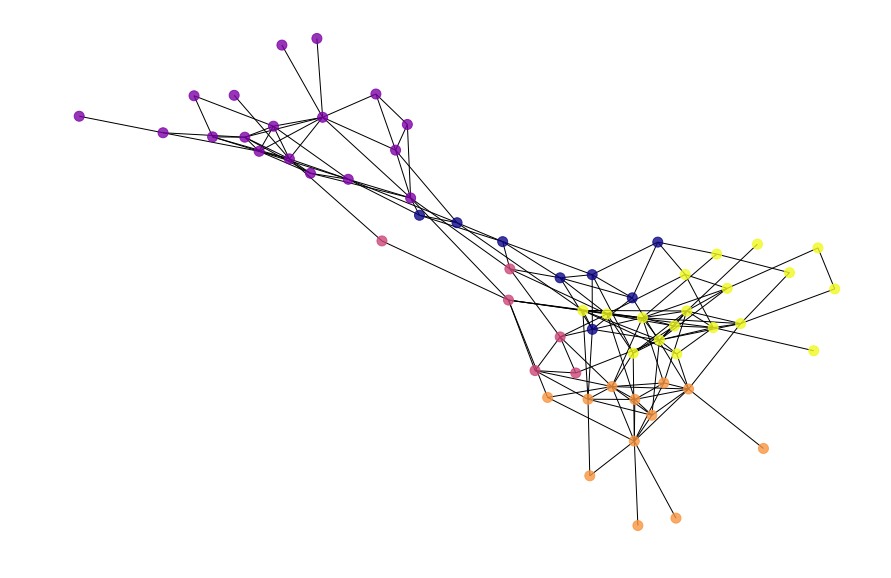

In [10]:
plt.figure(figsize=(15,10))
pos = nx.spring_layout(G) 
        
nx.draw_networkx_nodes(G,pos,
                       cmap=plt.get_cmap('plasma'),
                       node_color=list(dict(nx.get_node_attributes(G,name_coms[0])).values()),
                       node_size=100,
                       alpha=0.8)

#width = 1+10*np.array(list(networkx.get_edge_attributes(g,'weight').values())).ravel()
#edge_color = np.random.uniform(size=len(width))

nx.draw_networkx_edges(G,pos)#"grey")
#plt.title("A bizarre graph")
plt.axis("off")
plt.show()

MODULARITY

In [11]:
from __future__ import division

from functools import wraps
from itertools import product

import networkx as nx
from networkx import NetworkXError
from networkx.utils import not_implemented_for
from networkx.algorithms.community.community_utils import is_partition

__all__ = ['coverage', 'modularity', 'performance']

class NotAPartition(NetworkXError):
    """Raised if a given collection is not a partition.

    """

    def __init__(self, G, collection):
        msg = '{} is not a valid partition of the graph {}'
        msg = msg.format(G, collection)
        super(NotAPartition, self).__init__(msg)


def modularity(G, communities, weight='weight'):
    
    if not is_partition(G, communities):
        raise NotAPartition(G, communities)

    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))
    return Q * norm

In [12]:
mod_louvain=modularity(G,comunidades_louvain[0])
mod_louvain

0.5188283691309657

# AHORA VIENE LO BUENO(?)

In [13]:
DistributionModularity = []                          # Vector para guardar las modularidades de cada iteracion
 
it =1000                                       # numero de iteraciones 
Grafo = G.copy()                      

for i in range(it):
    #Generar grafo recableado
    list_degrees=list(dict(Grafo.degree).values())
    GR=nx.configuration_model(list_degrees,create_using=nx.Graph)
    #Calcular los clusters usando TODOS los criterios
    comunidades_GR=all_communities(GR)
    #Calcular Mod y no se que ... 
    DistributionModularity.append(modularity(GR,comunidades_GR[0]))

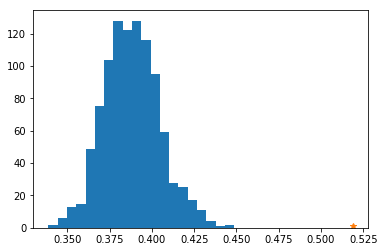

In [15]:
DM=np.array(DistributionModularity)
plt.hist(DM,bins=20)
plt.plot(mod_louvain,1,'*')